# Exploratory Data Analysis

### Table of contents

- [1. Imports](#1-imports)
- [2. Statistics](#2-statistics)
  - [2.1. Distributions](#21-distributions)
     - [2.1.1 Share of impressions in the dataset](#211-share-of-impressions-in-the-dataset)
     - [2.1.2 Age and Gender Distribution](#212-age-and-gender-distribution)
     - [2.1.3 Per-user enagagement profile](#213-per-user-enagagement-profile)
  - [2.2. User Activity](#22-user-activity)
     - [2.2.1. Distribution of User Activity](#221-distribution-of-user-activity)
     - [2.2.2. User demographics and their activity](#222-user-demographics-and-their-activity)
  - [2.3. Temporal analysis of engagement](#23-temporal-analysis-of-engagement)
- [3. Missing Data](#3-missing-data)
  - [3.1. Column-level](#31-column-level)
  - [3.2. Handling missing values](#32-handling-missing-values)
- [4. Correlations](#4-data-cleaning)
  - [4.1. Dropping Duplicates](#41-dropping-duplicates)
  - [4.2. Creating popularity features with PCA](#42-creating-popularity-features-with-pca)
- [5. Outlier Detection and Handling](#5-outlier-detection-and-handling)
    - [5.1. Transforming variables](#51-transforming-variables)
- [6. Feature Engineering](#6-feature-engineering)
    - [6.1. Filtering early actions](#61-filtering-early-actions)
    - [6.2. Engagement Features based on early actions of users](#62-engagement-features-based-on-early-actions-of-users)
- [7. Creating the user-level dataset](#7-creating-the-user-level-dataset)
    - [7.1. Merging and aggregating with impression-level features](#71-merging-and-aggregating-with-impression-level-features)
    - [7.2. Correlations](#72-correlations)
    - [7.3. User-level distributions](#73-user-level-distributions)
    - [7.4. Saving the dataset](#74-saving-the-dataset)



### 1. Imports

In [197]:
!pip install matplotlib
!pip install seaborn
%pip install scipy
!pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [198]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, scipy.stats as st
from scipy.stats import pointbiserialr
from scipy import stats
from sklearn.decomposition import PCA


#### Reading the data

In [199]:
# =========================
# 0) Load data
# =========================
df = pd.read_csv("../data/users_with_actions.csv")
df.drop("registeredMonthCnt", axis=1, inplace=True)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns.")

# =========================
# 1) Define action columns
# =========================
click_col = 'isClick'
other_actions = ['isLike', 'isComment', 'isShare', 'isViewComment', 'isIntoPersonalHomepage']
all_actions = [
    'isClick',
    'isComment',
    'isIntoPersonalHomepage',
    'isShare',
    'isViewComment',
    'isLike',
    'mlogViewTime'
]

# =========================
# 2) Count actions per impression and cumulative per user
# =========================
df['num_actions_row'] = df[all_actions].sum(axis=1)

df = df.sort_values(['userId', 'dt', df.index.name or 'mlogId'])

df['cum_actions'] = df.groupby('userId')['num_actions_row'].cumsum()

# rows strictly AFTER the first 3 accumulated actions
df_after10 = df[df['cum_actions'] > 3].copy()

# =========================
# 3) Weighted engagement 
# =========================
df_after10['weighted_score_row'] = (
    1 * df_after10['isClick'] +
    3 * df_after10['isLike'] +
    4 * df_after10['isComment'] +
    4 * df_after10['isShare'] +
    2 * df_after10['isViewComment']+
    2 * df_after10['isIntoPersonalHomepage']+
    0.01 * df_after10['mlogViewTime']
)

user_weighted = df_after10.groupby('userId')['weighted_score_row'].sum()
y_active_weighted = (user_weighted >= 4).astype(int).rename('y_active_weighted')
weighted_score_row = user_weighted.rename('weighted_score_row')

# =========================
# Last action day
# =========================
df['any_action'] = (df[all_actions].sum(axis=1) > 0).astype(int)

last_action_dt = (
    df[df['any_action'] == 1]
    .groupby('userId')['dt']
    .max()
    .rename('last_action_dt')
)

last_action_dt = last_action_dt.reindex(df['userId'].unique(), fill_value=0)

# =========================
# 4) Combine user-level labels
# =========================
user_labels = pd.concat([y_active_weighted, last_action_dt, user_weighted], axis=1)

# make sure columns exist
user_labels = user_labels.fillna(0)
user_labels['y_active_weighted'] = user_labels['y_active_weighted'].astype(int)
user_labels['last_action_dt'] = user_labels['last_action_dt'].astype(int)
user_labels['weighted_score_row'] = user_labels['weighted_score_row'].astype(float)

# final user-level label:
# deeply engaged AND last action after dt >= 10
user_labels['y_active'] = (
    (user_labels['y_active_weighted'] == 1) &
    (user_labels['last_action_dt'] >= 10)
).astype(int)

# =========================
# 5) Map label back to full df
# =========================

# drop any old y_active in df
df = df.drop(columns=['y_active'], errors='ignore')

# now merge in the new label
df = df.merge(
    user_labels[['y_active','weighted_score_row' ]],
    left_on='userId',
    right_index=True,
    how='left'
)
# fill and cast once
df[['y_active']] = df[['y_active']].fillna(0).astype(int)


# =========================
# 6) Clean up helper columns 
# =========================
df.drop(columns=['num_actions_row', 'cum_actions', 'any_action'],
        inplace=True, errors='ignore')
df_after10.drop(columns=['weighted_score_row'],
                inplace=True, errors='ignore')

# =========================
# 7) Quick checks
# =========================
print("Impression-level y_active distribution:")
print(df['y_active'].value_counts())

user_flags = df.groupby('userId')['y_active'].max()
print("\nUser-level y_active distribution:")
print(user_flags.value_counts(normalize=True))


Data loaded: 117386 rows, 34 columns.
Impression-level y_active distribution:
y_active
1    84325
0    33061
Name: count, dtype: int64

User-level y_active distribution:
y_active
0    0.708117
1    0.291883
Name: proportion, dtype: float64


### 2. Statistics

In [200]:
print(df.info())
print(df.describe())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 117386 entries, 59380 to 43865
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             117386 non-null  int64  
 1   impressPosition                117386 non-null  int64  
 2   impressTime                    117386 non-null  int64  
 3   isClick                        117386 non-null  int64  
 4   isComment                      117386 non-null  int64  
 5   isIntoPersonalHomepage         117386 non-null  int64  
 6   isShare                        117386 non-null  int64  
 7   isViewComment                  117386 non-null  int64  
 8   isLike                         117386 non-null  int64  
 9   mlogId                         117386 non-null  object 
 10  mlogViewTime                   113450 non-null  float64
 11  userId                         117386 non-null  object 
 12  province                       1

### 2.1. Distributions

### 2.1.1 Share of impressions in the dataset
First, lets get a quick sense of how often non-click interactions occur on impressions: likes, view comment, shares, comments. This gives us a baseline for sparsity and helps decide which targets/features are viable for modeling.

In [201]:
# Simple statistics
print("\nBasic impression statistics:")
cols = ["isLike", "isViewComment", "isShare", "isComment", "isClick", "isIntoPersonalHomepage"]
eng_stats = {}
for c in cols:
    if c in df.columns:
        eng_stats[c] = {
            "Total": int(df[c].sum()),
            "Share of total impressions": round(df[c].mean()*100, 2),
        }

eng_df = pd.DataFrame(eng_stats).T
print(eng_df)


Basic impression statistics:
                           Total  Share of total impressions
isLike                    7183.0                        6.12
isViewComment            11378.0                        9.69
isShare                   1160.0                        0.99
isComment                  299.0                        0.25
isClick                 117318.0                       99.94
isIntoPersonalHomepage    2043.0                        1.74


#### Visualization

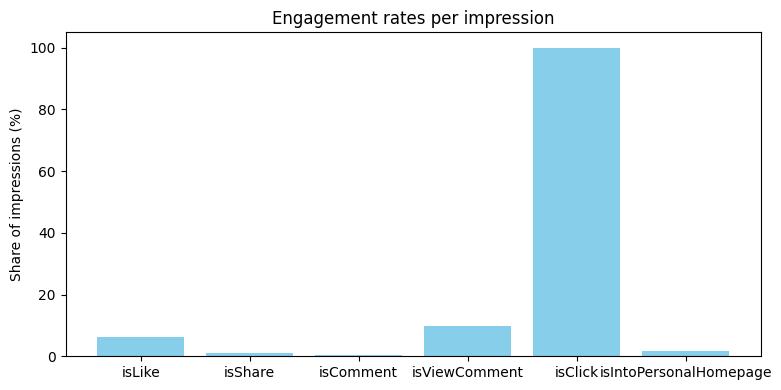

In [202]:
eng_cols = ["isLike", "isShare", "isComment", "isViewComment", "isClick", "isIntoPersonalHomepage"]

eng_rates = {}
for c in eng_cols:
    if c in df.columns:
        eng_rates[c] = df[c].mean() * 100  

# Engagement rates per impression
plt.figure(figsize=(8,4))
plt.bar(eng_rates.keys(), eng_rates.values(), color="skyblue")
plt.ylabel("Share of impressions (%)")
plt.title("Engagement rates per impression")
plt.tight_layout()
plt.show()

#### Interpretation
Shares and comments are vanishingly rare at the impression level (≤1%). Likes are also rare (~7%). Only “view comment” reaches ~10% and nearly every action is at least a click.

#### Implications

Clicks are the main interaction type and the basis of every action. Actions that require intent after the click (like/share/comment) are orders of magnitude rarer. Predicting likes/shares/comments per impression might be unstable due to class imbalance.

### 2.1.2 Age and Gender Distribution

We visualize the user age and gender distribution (one row per user) to understand demographic coverage and to judge whether age- or gender-related effects will be identifiable. A concentrated age/gender mass implies that age will explain only a small share of variance; sparse tails require careful reporting (or pooling) to avoid noisy conclusions.

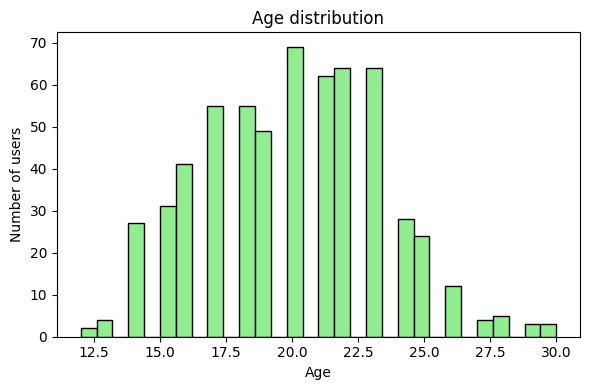

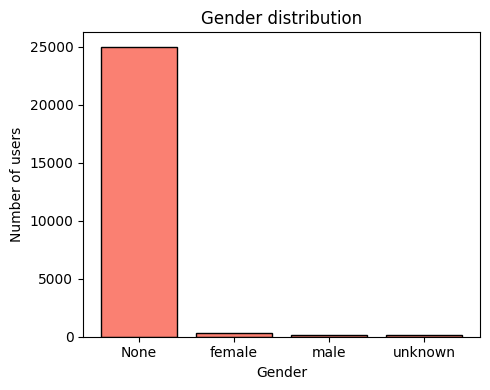

In [203]:
# Age distribution
user_level = df.groupby('userId').agg({
    'age': 'first',
    'gender': 'first',
    'weighted_score_row': 'sum'
}).reset_index()
if "age" in user_level.columns:
    plt.figure(figsize=(6,4))
    plt.hist(user_level["age"].dropna(), bins=30, color="lightgreen", edgecolor="black")
    plt.xlabel("Age")
    plt.ylabel("Number of users")
    plt.title("Age distribution")
    plt.tight_layout()
    plt.show()

# Gender distribution
if "gender" in user_level.columns:
    gender_counts = user_level["gender"].value_counts(dropna=False)
    plt.figure(figsize=(5,4))
    plt.bar(gender_counts.index.astype(str), gender_counts.values, color="salmon", edgecolor="black")
    plt.xlabel("Gender")
    plt.ylabel("Number of users")
    plt.title("Gender distribution")
    plt.tight_layout()
    plt.show()

#### Implications

The population is predominantly 17–23. Skewness is modest but because the 25+ cohort is small, age effects beyond 25 are underpowered.

For gender a large “nan/missing” bucket exists. The other buckets are tiny.

### 2.1.3 Per-user enagagement profile

The next step is to collapse impression rows into one row per user so we can study how activity and engagement vary across the population.

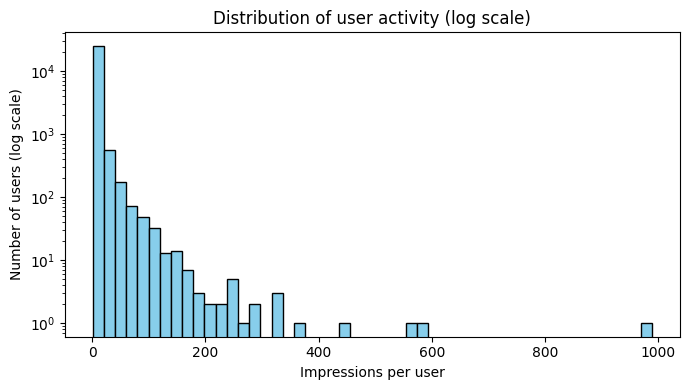

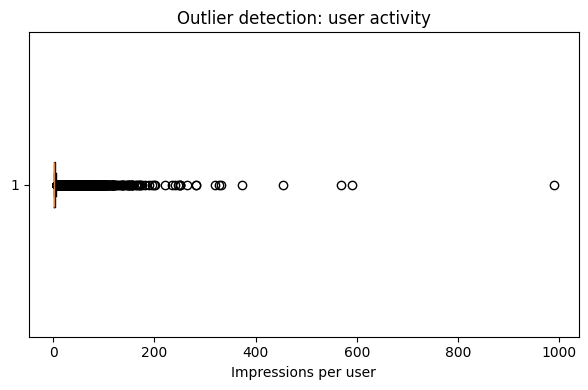

Mean impressions per user: 4.59
Median impressions per user: 2.00


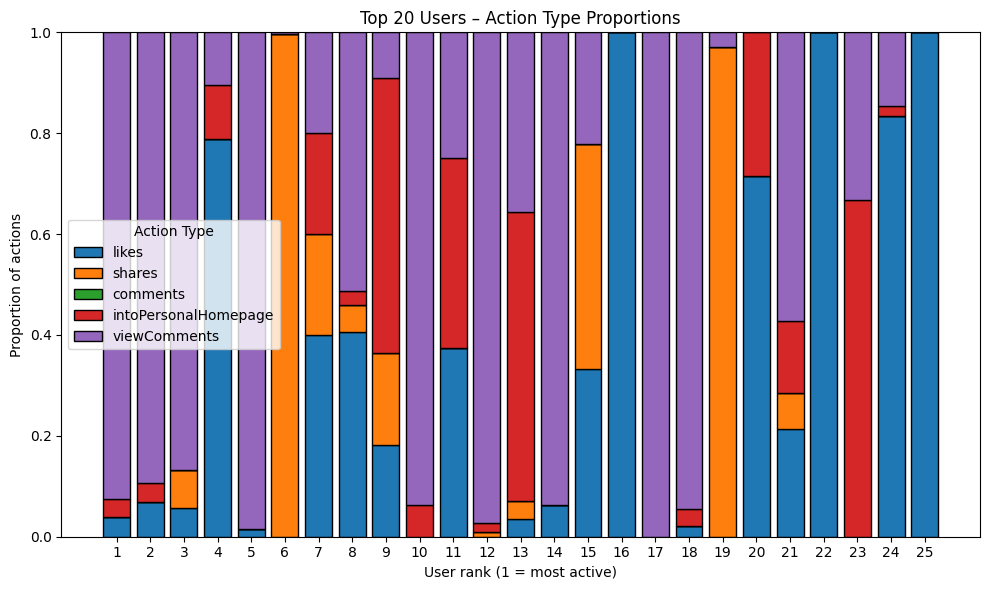

In [204]:
# Per-user aggregation
user_agg = df.groupby("userId").agg(
    impressions = ("mlogId","count"),
    clicks      = ("isClick","sum"),
    likes       = ("isLike","sum"),
    shares      = ("isShare","sum"),
    comments    = ("isComment","sum"),
    intoPersonalHomepage = ("isIntoPersonalHomepage","sum"),
    viewComments= ("isViewComment","sum"),
    mlogViewTime= ("mlogViewTime","sum")
).reset_index()

#Impressions per user distribution
plt.figure(figsize=(7,4))
plt.hist(user_agg["impressions"], bins=50, log=True, color="skyblue", edgecolor="black")
plt.xlabel("Impressions per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of user activity (log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(user_agg["impressions"], vert=False)
plt.xlabel("Impressions per user")
plt.title("Outlier detection: user activity")
plt.tight_layout()
plt.show()

# Mean impressions per user
mean_impressions = user_agg["impressions"].mean()
print(f"Mean impressions per user: {mean_impressions:.2f}")
print(f"Median impressions per user: {user_agg['impressions'].median():.2f}")


actions = ["likes", "shares", "comments", "intoPersonalHomepage", "viewComments"]

top_users = user_agg.sort_values("impressions", ascending=False).head(25).copy()
top_users["user_rank"] = range(1, len(top_users) + 1)
top_users["total_actions"] = top_users[actions].sum(axis=1)

for a in actions:
    top_users[a + "_prop"] = top_users[a] / top_users["total_actions"]

prop_cols = [a + "_prop" for a in actions]
label_map = dict(zip(prop_cols, actions))

top_users_sorted = top_users.sort_values("user_rank")

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(top_users_sorted))
for col in prop_cols:
    plt.bar(
        top_users_sorted["user_rank"],
        top_users_sorted[col],
        bottom=bottom,
        label=label_map[col],
        edgecolor="black"
    )
    bottom += top_users_sorted[col].values

plt.xlabel("User rank (1 = most active)")
plt.ylabel("Proportion of actions")
plt.title("Top 20 Users – Action Type Proportions")
plt.xticks(top_users_sorted["user_rank"])
plt.legend(title="Action Type")
plt.tight_layout()
plt.show()


#### Implications

The heavy-tailed histogram (on log scale) and the long right tail in the boxplot mean a small fraction of users see a lot of impressions.
Four users performed over 400 actions, with a single user who performed almost 1000 actions. Most users have less than 10 actions with a mean of 4.59 impressions  and a median of 2 impressions per user. 

The action type proportions of the top 20 users with the highest weighted score shows that the most active users seem to have one main "favorite" type of interacting with the content. Most users view comments a lot, some users share content as a main form of interaction, others like a lot of content, but commenting seems to rarely be the main form of interacting with the suggested content.



### 2.2. User Activity
### 2.2.1. Distribution of User Activity
We want to understand how the user's weighted score is distributed across users. This informs whether activity is concentrated or broad, sensible cutoffs for “more active” cohorts, how much variance weighted score can explain in downstream EDA.

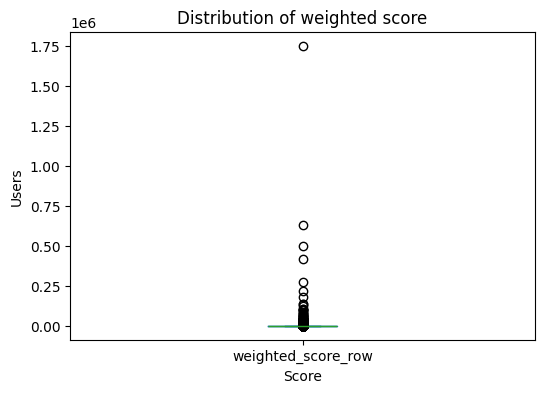

count      25589.00
mean         410.64
std        12875.11
min            0.00
10%            1.04
25%            1.11
50%            4.21
75%           18.48
90%          111.37
max      1750521.30
Name: weighted_score_row, dtype: float64


In [205]:
# Histogram
# Group impressions by users
user_level = df.groupby('userId').agg({
    'weighted_score_row': 'sum',
    'age' : 'first',
    'gender': 'first',
    'province': 'first'
}).reset_index()
fig = plt.figure(figsize=(6,4))
user_level['weighted_score_row'].dropna().plot(kind='box')
plt.title('Distribution of weighted score')
plt.xlabel('Score'); plt.ylabel('Users')
plt.show()

# Summary stats and median
print(user_level['weighted_score_row'].describe(percentiles=[.1,.25,.5,.75,.9]).round(2))


#### Interpretation

The weighted score box plots follows a similar pattern as the box plot for number of impressions per user. A few users show significantly higher scores than the majority of users.

The mean score is ~411 but the standard deviation is around ~13,000 which underscores our previous finding. The median score is 4.21, which is the baseline for our threshold definition, defining users with a score above 4 as active users.

### 2.2.2. User demographics and their activity

The next step is to explore whether user demographics are associate with their activity.

#### Age and user activity


score by age_bin:
          count    mean  median
age_bin                       
≤18        215  971.12    6.20
19–25      360  684.67    4.73
26–35       27   35.32    4.06
36–50        0     NaN     NaN
51+          0     NaN     NaN


/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_35822/1312484407.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atab = (user_level.groupby('age_bin')['weighted_score_row']


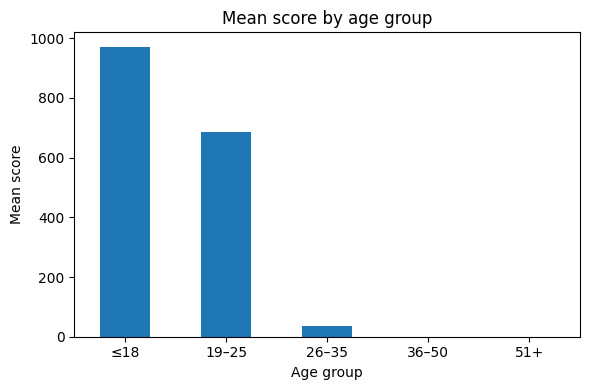

Spearman rho(age, score) = -0.065, p = 0.1115


In [206]:
if 'age' in user_level.columns:
    # 1) Basic summary on observed ages
    age_obs = user_level.loc[user_level['age'].notna(), ['age','weighted_score_row']].copy()
    age_obs['age'] = pd.to_numeric(age_obs['age'], errors='coerce')
    age_obs = age_obs.dropna(subset=['age'])

    # 2) Age bins for readable tables/plots
    bins = [0, 18, 25, 35, 50, 120]
    labels = ['≤18','19–25','26–35','36–50','51+']
    user_level['age_bin'] = pd.cut(pd.to_numeric(user_level['age'], errors='coerce'), bins=bins, labels=labels, right=True)

    atab = (user_level.groupby('age_bin')['weighted_score_row']
                 .agg(['count','mean','median'])
                 .round(2)
                 .sort_values('mean', ascending=False))
    print("\nscore by age_bin:\n", atab)

    # Plot mean user_level by age_bin
    fig = plt.figure(figsize=(6,4))
    atab['mean'].plot(kind='bar')
    plt.title('Mean score by age group'); plt.ylabel('Mean score'); plt.xlabel('Age group')
    plt.xticks(rotation=0); plt.tight_layout(); plt.show()

    # Spearman correlation (non-parametric) on observed ages
    if len(age_obs) > 10:
        rho, pval = stats.spearmanr(age_obs['age'], age_obs['weighted_score_row'])
        print(f"Spearman rho(age, score) = {rho:.3f}, p = {pval:.4g}")



#### Interpretation

The analysis shows a negative relationship between age and user activity, but also shows the lack of demographic user data.
Users <18 have the highest mean user_level (≈971), followed by the 19–25 group (≈684). No older users (36+) are represented in the sample, which is expected given the young user base of newly registered accounts.

The Spearman correlation between age and user_level is small (ρ ≈ -0.065, p < 0.12), indicating that the results are not significant.

Overall, these results cannot be interpreted, as the count of users in each age group is too low to explain anything for the whole user base.

#### Gender and provinces per user activity


score by gender:
          count    mean  median
gender                        
female     285  846.35    7.96
male       189  740.86    4.34
unknown    128  585.90    4.27


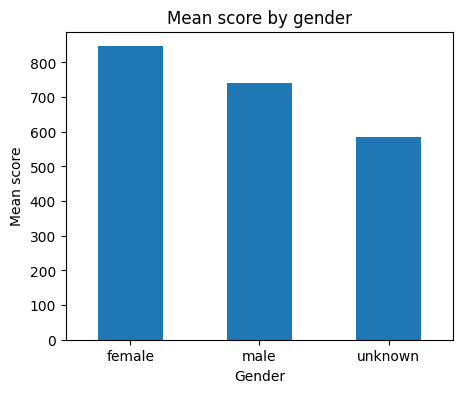


Top provinces by mean score:
             count    mean  median
province                         
an hui        721  972.09    4.30
shan dong    1550  703.04    4.14
wei zhi      1092  580.19    4.28
hu nan       1076  451.36    4.31
guang xi      786  394.12    3.96
bei jing     1066  377.99    4.26
xin jiang    1497  331.08    4.75
guang dong   2699  288.53    4.17
shan xi      1366  227.04    4.22
jiang su     1229  210.83    4.07


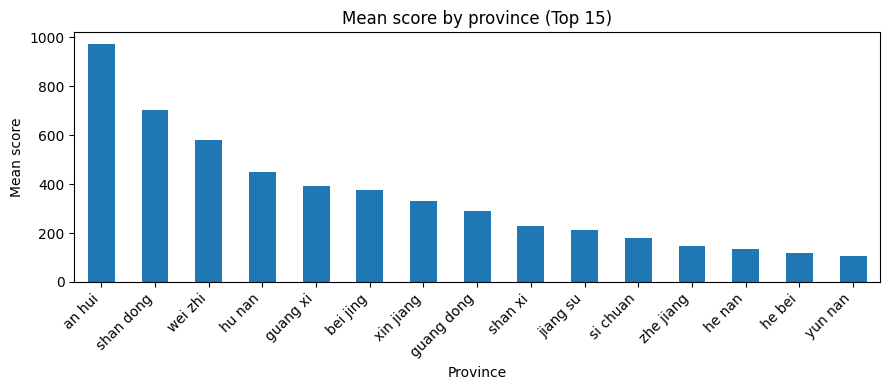

In [207]:
# Gender
if 'gender' in user_level.columns:
    gtab = (user_level.groupby('gender')['weighted_score_row']
                  .agg(['count','mean','median']).round(2)
                  .sort_values('mean', ascending=False))
    print("\nscore by gender:\n", gtab)

    fig = plt.figure(figsize=(5,4))
    gtab['mean'].plot(kind='bar')
    plt.title('Mean score by gender'); plt.ylabel('Mean score'); plt.xlabel('Gender')
    plt.xticks(rotation=0); plt.show()

# Province (top 15 by users)
if 'province' in user_level.columns:
    top_prov = user_level['province'].value_counts().head(15).index
    ptab = (user_level.loc[user_level['province'].isin(top_prov)]
                 .groupby('province')['weighted_score_row']
                 .agg(['count','mean','median'])
                 .sort_values('mean', ascending=False).round(2))
    print("\nTop provinces by mean score:\n", ptab.head(10))

    fig = plt.figure(figsize=(9,4))
    ptab['mean'].plot(kind='bar')
    plt.title('Mean score by province (Top 15)'); plt.ylabel('Mean score'); plt.xlabel('Province')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


#### Interpretation

Across gender groups, female users show slightly higher activity levels than both male and unknown users. This indicates that **female users tend to engage somewhat more actively** on the platform. However, the differences are moderate and the count per group is very low, suggesting that gender alone is not a dominant factor in predicting user activity and important demographic information is missing for the majority of users.

Looking at geographic patterns, users from An Hui, Shan Dong, and Wei Zhi display the highest average activity levels, while users from provinces such as Sichuan show slightly lower engagement. Although regional differences exist, they remain **relatively small** in absolute terms, implying that location may influence engagement to some extent but it is unlikely to be a strong standalone predictor of user activity.

#### Types and user activity


Average interaction rates by type (impression level):
 type                         1       2
isClick                 0.9991  0.9997
isLike                  0.0575  0.0643
isShare                 0.0071  0.0122
isComment               0.0039  0.0014
isViewComment           0.0384  0.1456
isIntoPersonalHomepage  0.0107  0.0230


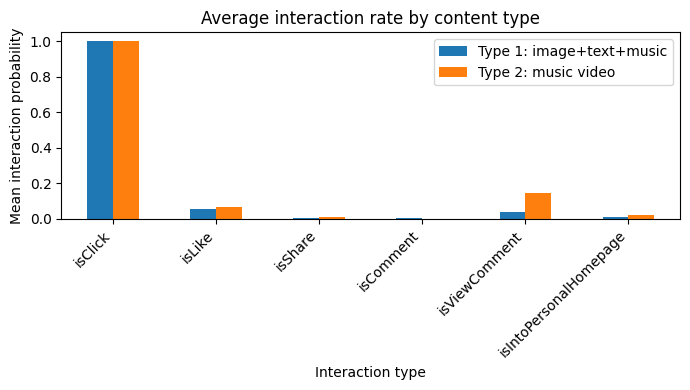


Paired t-test (click rate: type1 vs type2): t=-1.593, p=0.1112
Mean click rate difference (type1 - type2): -0.0004


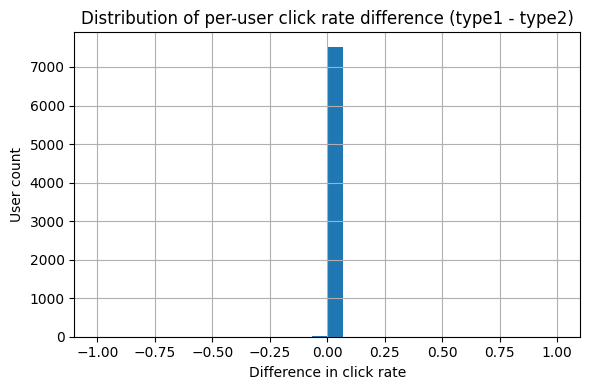

In [208]:
# Ensuring type is numeric (1 or 2)
df['type'] = pd.to_numeric(df['type'], errors='coerce').astype('Int64')

# Defining key interaction columns
interaction_cols = ['isClick','isLike','isShare','isComment','isViewComment','isIntoPersonalHomepage']

# 1) Impression-level averages by type
itype = (
    df.groupby('type')[interaction_cols]
      .mean()
      .round(4)
      .T  # transpose for easier plotting
)
print("\nAverage interaction rates by type (impression level):\n", itype)

# Plot
fig, ax = plt.subplots(figsize=(7,4))
itype.plot(kind='bar', ax=ax)
plt.title('Average interaction rate by content type')
plt.ylabel('Mean interaction probability')
plt.xlabel('Interaction type')
plt.xticks(rotation=45, ha='right')
plt.legend(['Type 1: image+text+music', 'Type 2: music video'])
plt.tight_layout()
plt.show()

# 2) User-level aggregation: each user’s mean interaction rate per type
u_interactions = (
    df.groupby(['userId','type'])[interaction_cols]
      .mean()
      .reset_index()
      .pivot(index='userId', columns='type', values='isClick')  # Example: click rate
)
u_interactions.columns = ['click_rate_type1','click_rate_type2']

# Paired comparison (users who saw both types)
both = u_interactions.dropna()
t_stat, p_val = stats.ttest_rel(both['click_rate_type1'], both['click_rate_type2'])
print(f"\nPaired t-test (click rate: type1 vs type2): t={t_stat:.3f}, p={p_val:.4g}")

# 3) summarize differences
mean_diff = both['click_rate_type1'].mean() - both['click_rate_type2'].mean()
print(f"Mean click rate difference (type1 - type2): {mean_diff:.4f}")

# 4) Visualization: per-user difference
fig, ax = plt.subplots(figsize=(6,4))
(both['click_rate_type1'] - both['click_rate_type2']).hist(bins=30, ax=ax)
plt.title('Distribution of per-user click rate difference (type1 - type2)')
plt.xlabel('Difference in click rate')
plt.ylabel('User count')
plt.tight_layout()
plt.show()



#### Interpretation

Click rates are almost identical across content types (≈ 99.9%), with no statistically significant difference (t = –1.59, p = 0.1112). This suggests that initial engagement—opening or playing a card—is not influenced by format.


Music videos and image cards perform equally in attracting user attention (clicks) but diverge in post-click behavior. Videos foster deeper exploration and creator engagement, whereas image cards generate lighter but broader appreciation signals. This distinction is crucial for recommender design—video content might sustain engagement depth, while static content supports surface-level breadth.


### 2.3. Temporal analysis of engagement

In this section we aim to plot temporal patterns in user activity. We will explore whether active users interact more consistently over time.

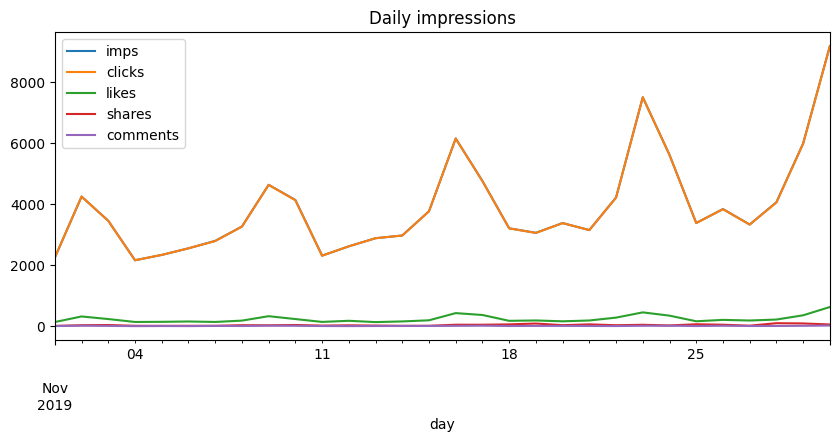

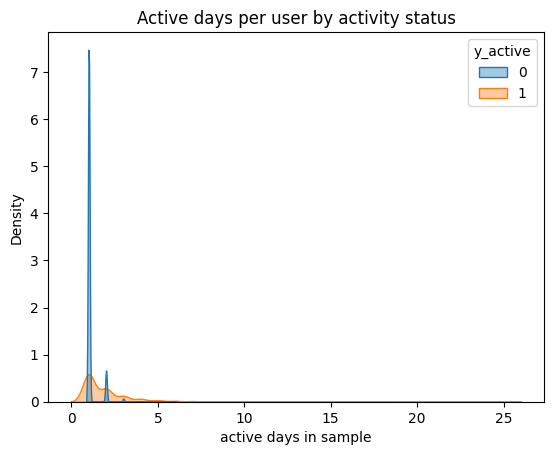

In [209]:
# reconstruct calendar day 
df["day"] = pd.to_datetime("2019-11-01") + pd.to_timedelta(df["dt"] - 1, unit="D")

# deterministic within-day ordering: (dt, impressPosition) as proxy
df = df.sort_values(["userId", "dt", "impressPosition"], kind="mergesort")

# early window
K = 30
df["rank_k"] = df.groupby("userId")["dt"].cumcount() + 1  
early = df.groupby("userId").head(K)

# daily features
daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum")).reset_index()

# user active-days metric
user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days")

daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum"), likes=("isLike","sum"), shares=("isShare","sum"), comments=("isComment","sum"))
daily.plot(title="Daily impressions", figsize=(10,4)); plt.show()


user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days").reset_index()
active_days = active_days.merge(df[["userId","y_active"]].drop_duplicates(), on="userId", how="left")

sns.kdeplot(data=active_days, x="active_days", hue="y_active", fill=True, common_norm=False, alpha=0.4)
plt.title("Active days per user by activity status"); plt.xlabel("active days in sample"); plt.show()



#### Interpretation

1) Daily impressions

The time series shows clear weekly cyclicality: user activity peaks roughly every 6–7 days, most likely on weekends, reflecting typical leisure-time engagement patterns in entertainment platforms.
Click volumes (orange line) dominate across all days and drive overall impression dynamics.
Likes, shares, and comments remain at much lower and stable levels, indicating consistent but limited social interaction behavior relative to total consumption.
The pattern suggests that user engagement is predictably periodic, driven by external temporal factors (e.g., weekend availability) rather than random fluctuations.

2) Active days by activity status

The kernel density plot shows that most users are active on only 1–2 days during the 30-day period, regardless of whether they are labeled as active (y_active=1) or inactive (y_active=0).
However, active users (orange) show a slightly broader right tail, indicating that they return more often and have a higher probability of multi-day engagement. Non-active users are mostly active on only one day.
This implies a strong short-term engagement bias across the platform: most users interact briefly, and sustained activity is rare.

#### Feature Engineering Weekend

Adding an isWeekend feature makes sense both behaviorally and statistically, especially given the pattern visible in the plot: there are recurring peaks roughly every seven days, which likely correspond to weekends (higher user activity).

In [210]:
# Create weekend dummy
df['isWeekend'] = (df['day'].dt.dayofweek >= 5).astype(int)


### 3. Missing Data
### 3.1. Column-level

Next, we will load the merged dataset to prepare it for modeling and explore relationships.

In [211]:
to_num = lambda s: pd.to_numeric(s, errors='coerce')

# obviously invalid values as missing 
special_nan = {
    'age': lambda s: s.where((s>=10) & (s<=100)),         
    'mlogViewTime': lambda s: s.where(s>=0),               
}

df_chk = df.copy()
for col, fn in special_nan.items():
    if col in df_chk.columns:
        df_chk[col] = fn(to_num(df_chk[col]))

def missing_table(frame):
    out = []
    n = len(frame)
    for c in frame.columns:
        miss = frame[c].isna().mean()
        dtype = frame[c].dtype
        # “special zero” flag example for dwell time
        special_zero = np.nan
        if c == 'mlogViewTime':
            special_zero = (frame[c].fillna(0).eq(0).mean())  # share of zeros
        out.append([c, dtype, miss, special_zero])
    tab = pd.DataFrame(out, columns=['column','dtype','missing_rate','share_eq_zero'])
    return tab.sort_values('missing_rate', ascending=False)

miss_tab = missing_table(df_chk)
print(miss_tab.head(20).to_string(index=False))

                column   dtype  missing_rate  share_eq_zero
                gender  object      0.962755            NaN
                   age float64      0.962755            NaN
             contentId  object      0.190798            NaN
          mlogViewTime float64      0.033530       0.050083
           publishTime float64      0.000315            NaN
             creatorId  object      0.000315            NaN
         creator_level float64      0.000315            NaN
       PushlishMlogCnt float64      0.000315            NaN
           creatorType float64      0.000315            NaN
                  type   Int64      0.000315            NaN
                talkId float64      0.000315            NaN
                    dt   int64      0.000000            NaN
       impressPosition   int64      0.000000            NaN
           impressTime   int64      0.000000            NaN
isIntoPersonalHomepage   int64      0.000000            NaN
             isComment   int64      0.00

#### Implications

- Severe missingness:
gender, age, and age_bin each have ~96% missing values, meaning demographic data for users is largely unavailable. These variables are unsuitable for direct modeling unless imputed or used for robustness checks only.

- Moderate missingness:
contentId has ~19.1% missing, potentially due to anonymized or unclassified content categories. Since this variable captures the thematic identity of a card, missing values should be treated carefully (e.g., introducing a “missing content” category).

- Minor missingness:
Variables like mlogViewTime show only 3.4% missingness, which is manageable and likely due to incomplete view-duration tracking.
A small number of card- or creator-level variables (creatorId, creator_level, PushlishMlogCnt, etc.) have negligible missingness (~0.032%), which can safely be dropped.

### 3.2. Handling missing values

- Age and gender: 
Dropping the columns but engineering age_missing and gender_missing as an indicator.

- ContentId:
values are replaced with an “unknown” category.

- MlogViewTime:
Missing values are replaced with zero.

In [212]:
print("Rows df:", len(df))
# making sure nan is consistent
def to_na(s: pd.Series):
    return (s.astype(str).str.strip()
            .replace({"": np.nan, "nan": np.nan, "None": np.nan,
                      "unknown": np.nan, "UNKNOWN": np.nan}))

#Dropping age and gender
df["age_missing"] = df["age"].isna().astype("uint8")
df["gender_missing"] = df["gender"].isna().astype("uint8")
df = df.drop(columns=["age", "gender"])

# contentID
df["contentId"] = to_na(df["contentId"]).fillna("unknown").astype("string")

#MlogViewTime
df["mlogViewTime"].fillna(0)

df = df.dropna(subset=["creatorId"]).reset_index(drop=True)
df = df[df["creatorId"].notna()].reset_index(drop=True)

print("Remaining rows after dropping missing creatorId:", len(df))


Rows df: 117386
Remaining rows after dropping missing creatorId: 117349




### 4. Correlations

The next step is to quantify linear relationships among numeric features at the impression level. We do this to flag near-duplicate variables (e.g., two timestamps) and multicollinearity risks for models.

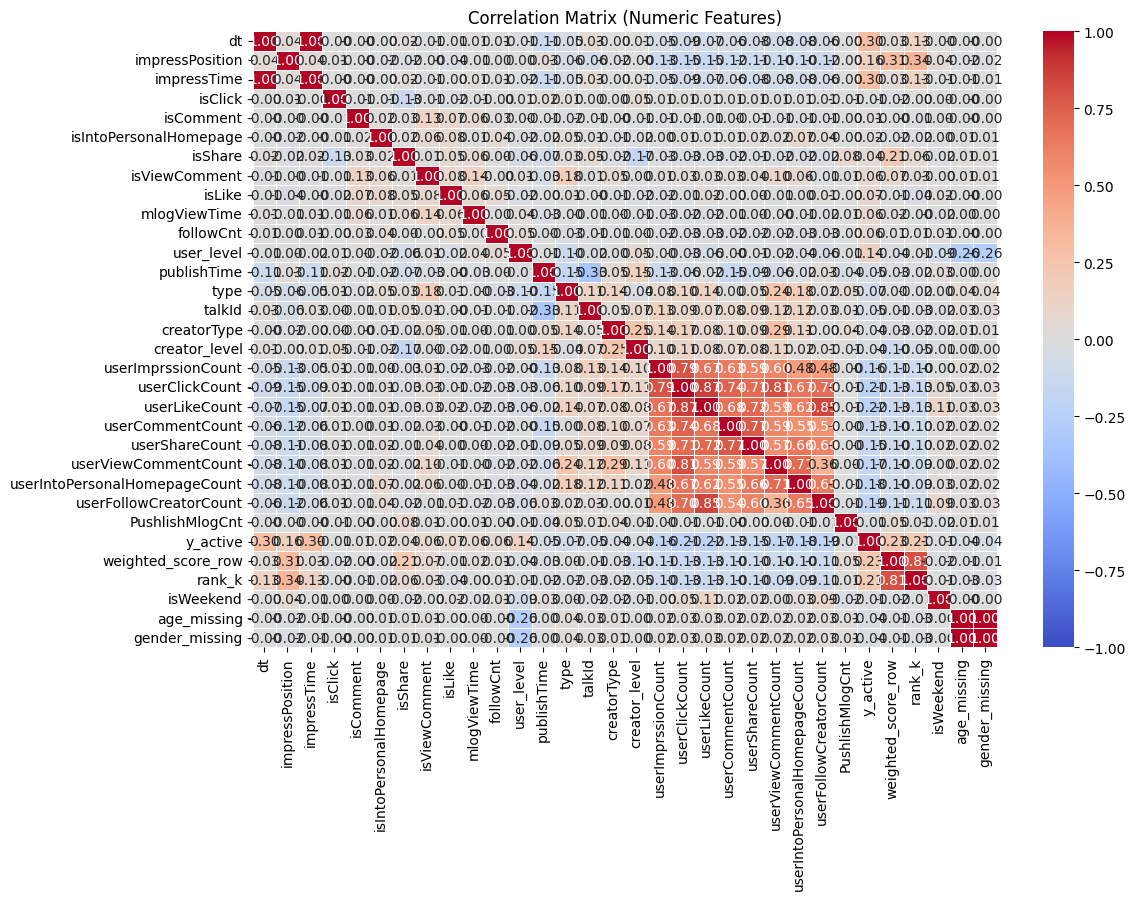

In [213]:
# Selecting only numeric columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Computing correlation matrix
corr = numeric_df.corr()

# Displaying as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

#### Interpretation
##### Duplicates
- **dt ↔ impressTime ≈ 1.00**
→ They encode the same time information 
- **age_missing ↔ gender_missing ≈ 1.00**
→ When age is missing, gender is missing too

#### Popularity variables

The correlation analysis revealed that all content popularity statistics—such as total impressions, clicks, likes, shares, and comments per mlog—are highly correlated with one another, often exceeding 0.7–0.9. These variables capture the same underlying construct: global content popularity at a given point in time. Including each of them individually would therefore introduce strong multicollinearity, inflate model variance, and make it difficult to interpret how popularity affects user activity.

### 4.1. Dropping duplicates

In [214]:
df.drop("impressTime", axis=1, inplace=True)
# Renaming age_missing to age_gender_missing
df.rename(columns={"age_missing": "age_gender_missing"}, inplace=True)
# Droping gender_missing
df.drop("gender_missing", axis=1, inplace=True)

### 4.2. Creating popularity features with PCA

In [215]:
pop_cols = [
    "userImprssionCount","userClickCount","userLikeCount","userCommentCount",
    "userShareCount","userViewCommentCount","userIntoPersonalHomepageCount",
    "userFollowCreatorCount"
]

# 1) log + within-day standardization
for c in pop_cols:
    if c in df:
        df[c+"_log"] = np.log1p(df[c].astype("float32"))
        df[c+"_log_zdt"] = df.groupby("dt")[c+"_log"].transform(
            lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
        ).astype("float32")

# Identifying standardized log-popularity features
z_cols = [c for c in df.columns if c.endswith("_log_zdt")]

# 1) Computing PCA first component across standardized log counts
pca = PCA(n_components=1, random_state=42)
df["pop_index_pca"] = pca.fit_transform(df[z_cols].fillna(0))[:, 0].astype("float32")


# 3) Dropping raw popularity variables
pop_related_cols = [c for c in df.columns if any(term in c for term in pop_cols)]
cols_to_drop = [c for c in pop_related_cols if c != "pop_index_pca"]
df = df.drop(columns=cols_to_drop, errors="ignore")


We combined several mlog-level popularity statistics (impressions, clicks, likes, shares, comments, etc.) into a single, standardized popularity index for modeling.

Each count variable was:
- Log-transformed to reduce skew from extremely popular content.
- Standardized within each day to remove differences in overall platform activity between days.
- Combined using PCA, where the first principal component captures the common popularity signal across all metrics.
- Lagged by one day (pop_index_pca_lag1) so the model only uses popularity information that would have been known before each impression.

#### Additional Popularity indizes

In [216]:
# 1) Compute content-level popularity index
content_pop_index = (
    df.groupby('contentId')['pop_index_pca']
      .mean()
      .rename('content_pop_index')
)

# 2) Merge back into your impression-level df
df = df.merge(content_pop_index, on='contentId', how='left')

creator_pop_index = (
    df.groupby('creatorId')['pop_index_pca']
      .mean()
      .rename('creator_pop_index')
)

df = df.merge(creator_pop_index, on='creatorId', how='left')

# Has user seen most popular content at the top?
# avoid division by zero
df['position_inv'] = 1 / (df['impressPosition'] + 1e-6)

# per-impression feed-quality exposure
df['pop_rank_exposure_row'] = np.log1p(np.abs(
    df['position_inv'] * df['pop_index_pca']
)).astype('float64')



Content-level popularity
- Group by contentId and take the mean of pop_index_pca → creates a per-content popularity score content_pop_index
- Merge this score back onto every impression row via contentId

Creator-level popularity
- Group by creatorId and take the mean of pop_index_pca → creates a per-creator popularity score creator_pop_index
- Merge this score back onto every impression row via creatorId

Popularity exposure metric
- Compute pop_rank_exposure_row as log1p(abs(position_inv * pop_index_pca))
- This combines how popular the item is (pop_index_pca) with how high it was shown in the feed (position_inv) into a single exposure measure per impression


### 5. Outlier Detection and Handling

We will create boxplots to see if the median of the feature is near the bottom of the box and there are many outliers above, then we will apply a log transform.

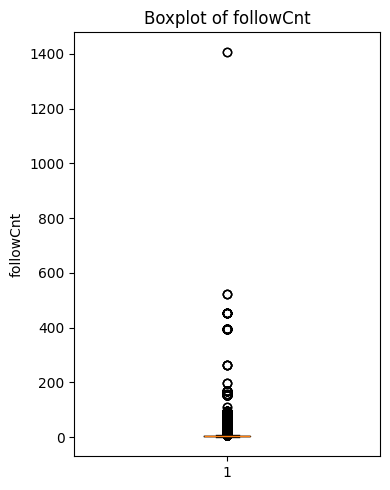

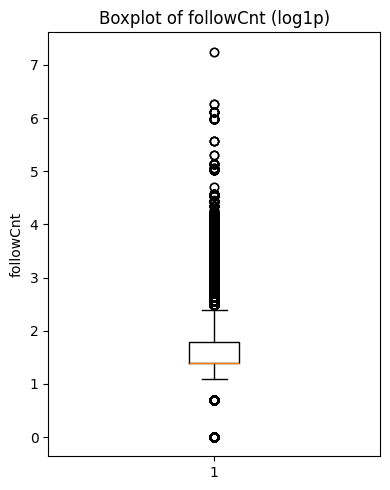

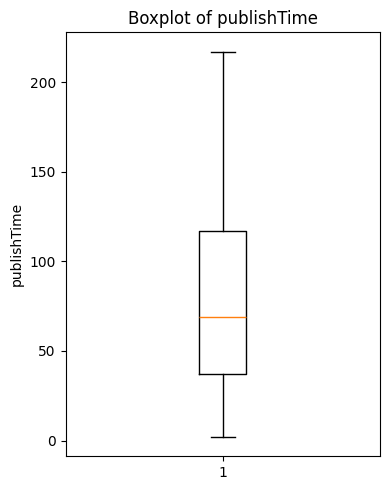

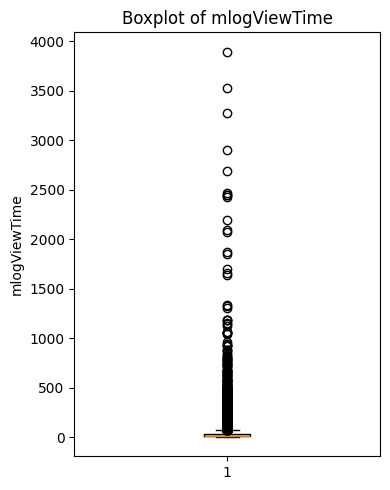

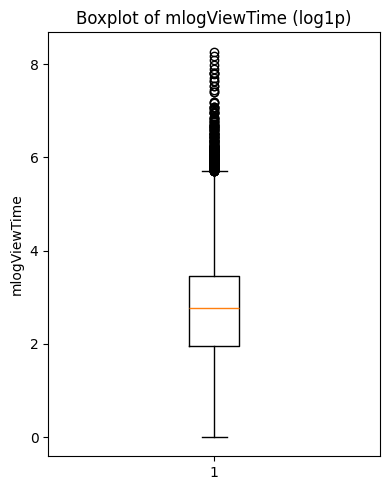

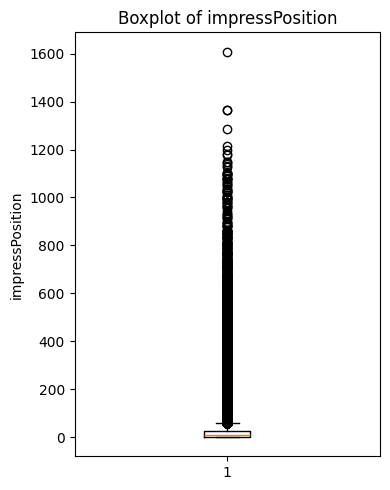

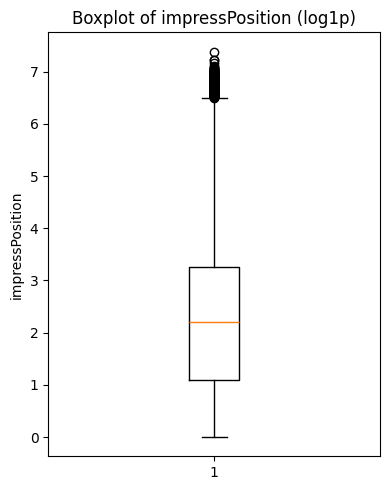

In [217]:

# Columns to plot
cols = ["followCnt", "publishTime", "mlogViewTime", "impressPosition"]

# Ensuring numeric types
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Function to create a boxplot
def plot_box(col, log=False):
    s = df[col].dropna()
    plt.figure(figsize=(4, 5))
    data = np.log1p(s) if log else s
    plt.boxplot(data, showfliers=True)
    plt.title(f"Boxplot of {col}" + (" (log1p)" if log else ""))
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# boxplot 
for col in cols:
    if col in ["mlogViewTime", "impressPosition", "followCnt"]:
        plot_box(col, log=False)
        plot_box(col, log=True)
    else:
        plot_box(col)

#### Interpretation

- Follow Count: The raw distribution is heavily right-skewed, with a large number of users following very few accounts and a small number following hundreds. This causes the boxplot to compress near zero. After applying a logarithmic transformation (log1p(followCnt)), the distribution becomes more balanced and visually interpretable. 
- Publish Time: The variable displays a relatively symmetric distribution with few outliers, suggesting that most posts are published within a similar time frame. No transformation is needed.
- Mlog View Time: This variable exhibits extreme skewness, with a small portion of users spending very long viewing times compared to the majority. The log-transformed version (log1p(mlogViewTime)) effectively reduces the influence of these outliers, making it the preferred representation for modeling.
- Impress Position: Most impressions occur at lower positions (around 1–20), yet some values exceed 200, which could indicate exceptionally deep scrolls. The log transformation again produces a more interpretable spread. 

### 5.1. Transforming variables

In [218]:
#Normalize & coerce numerics
for col in ["mlogViewTime", "followCnt", "impressPosition", "registeredMonthCnt", "publishTime"]:
    if col in df.columns:
        df[col] = pd.to_numeric(to_na(df[col]), errors="coerce")

# Cap stable numerics
if "registeredMonthCnt" in df:
    cap_reg_month = df["registeredMonthCnt"].quantile(0.99)
    if pd.notna(cap_reg_month):
        df.loc[df["registeredMonthCnt"] > cap_reg_month, "registeredMonthCnt"] = cap_reg_month

if "publishTime" in df:
    cap_pub = df["publishTime"].quantile(0.995)
    if pd.notna(cap_pub):
        df.loc[df["publishTime"] > cap_pub, "publishTime"] = cap_pub

# mlogViewTime: fill + cap positives + log 
if "mlogViewTime" in df:
    vt = df["mlogViewTime"].fillna(0).clip(lower=0).astype("float64")
    pos = vt > 0
    q_hi = vt.loc[pos].quantile(0.99)
    if pd.notna(q_hi):
        vt.loc[pos & (vt > q_hi)] = float(q_hi)
    df["mlogViewTime_filled"] = vt
    df["mlogViewTime_log"] = np.log1p(vt)

# impressPosition: 
if "impressPosition" in df:
    # treating 0 as invalid position (see Music Streaming paper)
    df.loc[df["impressPosition"] == 0, "impressPosition"] = np.nan
    df["impressPosition_missing"] = df["impressPosition"].isna().astype("uint8")
    imp_med_day = df.groupby("day", observed=True)["impressPosition"].transform("median") if "day" in df else np.nan
    imp_med_global = df["impressPosition"].median(skipna=True)
    df["impressPosition"] = df["impressPosition"].fillna(imp_med_day).fillna(imp_med_global)
    df["impressPosition_log"] = np.log1p(df["impressPosition"])

# followCnt log 
if "followCnt" in df:
    df["followCnt"] = pd.to_numeric(df["followCnt"], errors="coerce")
    df["followCnt_log"] = np.log1p(df["followCnt"].fillna(0).clip(lower=0))


# Checks
print({
    "mlogViewTime_log_na": float(df["mlogViewTime_log"].isna().mean()) if "mlogViewTime_log" in df else None,
    "impressPosition_log_na": float(df["impressPosition_log"].isna().mean()) if "impressPosition_log" in df else None,
    "followCnt_log_na": float(df["followCnt_log"].isna().mean()) if "followCnt_log" in df else None,
})
# Quick distribution check 
df[["followCnt", "followCnt_log", "mlogViewTime", "mlogViewTime_log", "impressPosition", "impressPosition_log"]].describe().T



{'mlogViewTime_log_na': 0.0, 'impressPosition_log_na': 0.0, 'followCnt_log_na': 0.0}


,count,mean,std,min,25%,50%,75%,max
followCnt,117349.0,5.261357,13.023062,0.000000,3.000000,3.000000,5.000000,1408.000000
followCnt_log,117349.0,1.602040,0.524735,0.000000,1.386294,1.386294,1.791759,7.250636
mlogViewTime,113450.0,23.656844,46.746001,0.000000,6.090000,14.770000,30.720000,3893.880000
mlogViewTime_log,117349.0,2.583288,1.117935,0.000000,1.868721,2.705380,3.434632,4.976757
impressPosition,117349.0,28.863207,67.856004,1.000000,2.000000,8.000000,25.000000,1609.000000
impressPosition_log,117349.0,2.353082,1.345639,0.693147,1.098612,2.197225,3.258097,7.383989


- Follow Count (followCnt): The raw variable had a wide range (0–1,408) with many extreme values. After applying a logarithmic transformation (log1p), the scale is compressed to 0–7.25, substantially reducing right skewness and making the variable more suitable for modeling.

- View Time (mlogViewTime): Previously dominated by a few very large viewing times (up to 3,893 seconds), the transformed version (mlogViewTime_log) now has a much smaller spread and a near-symmetric distribution. This ensures that long-tail observations no longer disproportionately influence the results.

- Impression Position (impressPosition): After applying a log transformation, the variable now ranges smoothly between 0.69 and 6.88. This retains interpretability while normalizing the scale.

### 6. Feature Engineering

This section constructs per-user features that capture behavioral intensity, diversity, and social interaction tendencies, using event-level data with action flags (`isClick`, `isLike`, `isShare`, etc.) and user metadata (`followCnt_log`, `creator_level`, etc.).

### 6.1. Filtering early actions
First, we will filter the dataset to only include early actions of each user so that we can engineer features based on these actions. We define early actions as the first 3 actions taken by a user. Additionally we filter those users, who performed their first action in the last 5 days of the observed timeframe, to avaoid analyzing behavior too early.

In [219]:
print("Number of rows before filtering:", len(df))

# 1) Computing first action day per user

first_action_dt = (
    df
      .groupby('userId')['dt']
      .min()
      .rename('first_action_dt')
)

# merge back so every row knows the user's first action day
df = df.merge(first_action_dt, left_on='userId', right_index=True, how='left')
df['first_action_dt'] = df['first_action_dt'].fillna(0).astype(int)

# 2) Excluding users where first action ≥ 25
excluded_users = df.loc[df['first_action_dt'] >= 25, 'userId'].unique()

print("Users excluded because first action >=25:", len(excluded_users))

df = df[~df['userId'].isin(excluded_users)].copy()

# 3) First 3 impressions per user
df = (
    df.sort_values(['userId', 'dt'])
      .groupby('userId')
      .head(3)
      .reset_index(drop=True)
)

print("Number of rows after filtering:", len(df))

df.drop(columns=['any_action', 'first_action_dt'], inplace=True, errors='ignore')


Number of rows before filtering: 117349
Users excluded because first action >=25: 5575
Number of rows after filtering: 37799


### 6.2. Engagement Features based on early actions of users

In [220]:

# Ensure binary ints
acts = ['isClick','isComment','isIntoPersonalHomepage','isShare','isViewComment','isLike']
for c in acts:
    df[c] = df[c].astype(int)

# Recover follow count in levels and keep log for interactions
df['follow_cnt'] = np.exp(df['followCnt_log'])

# ----- Per-user aggregates -----
grp = df.groupby('userId', as_index=True)

# Basic counts
agg = grp.agg(
    actions_taken = ('mlogId', 'count'),
    clicks   = ('isClick', 'sum'),
    likes    = ('isLike', 'sum'),
    comments = ('isComment', 'sum'),
    shares   = ('isShare', 'sum'),
    homeviews= ('isIntoPersonalHomepage','sum'),
    viewcoms = ('isViewComment','sum'),
    followCnt_log = ('followCnt_log','max')
)

# Normalized rates and ratios (safe denominators)
den_imp = agg['actions_taken'].clip(lower=1)
agg['like_rate']    = agg['likes']    / den_imp
agg['comment_rate'] = agg['comments'] / den_imp
agg['share_rate']   = agg['shares']   / den_imp

# Binary ever flags
agg['ever_shared']    = (agg['shares']   > 0).astype(int)
agg['ever_commented'] = (agg['comments'] > 0).astype(int)
agg['ever_inthomeviewed'] = (agg['homeviews'] > 0).astype(int)

# Action diversity (how many action types >0)
action_sums = agg[['clicks','likes','comments','shares','homeviews','viewcoms']]

# Shannon entropy across action counts
counts = action_sums.to_numpy(dtype=float)
row_sums = counts.sum(axis=1, keepdims=True)
p = np.divide(counts, np.where(row_sums==0, 1, row_sums), where=(row_sums!=0))
entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
entropy[row_sums.flatten()==0] = 0.0
agg['action_entropy'] = entropy

# Follow-weighted sharing (event-level -> user aggregates)
df['share_follow_evt'] = df['isShare'] * df['followCnt_log']

# Reach-propensity proxy
agg['shares_per_exp_follow'] = agg['shares'] / np.exp(agg['followCnt_log']).clip(lower=1)


# Interaction terms
# Sum of per-event (isAction * followCnt_log)
for a in ['isLike','isComment']:
    name = f'sum_{a}_x_followlog'
    agg[name] = df.groupby('userId').apply(lambda g: (g[a] * g['followCnt_log']).sum())

# followCnt_log × action_rate
agg['action_rate'] = (agg['clicks'] + agg['likes'] + agg['comments'] + agg['shares']) / den_imp
agg['followlog_x_actionrate'] = agg['followCnt_log'] * agg['action_rate']


# entropy seen over contentId and talkId
def _shannon_entropy(vals: pd.Series) -> float:
    p = vals.value_counts(normalize=True, dropna=True).to_numpy(dtype=float)
    if p.size == 0:
        return 0.0
    return float(-(p * np.log(p)).sum())

content_entropy = (
    df.groupby('userId')['contentId'].apply(_shannon_entropy).rename('content_entropy_seen')
)
talk_entropy = (
    df.groupby('userId')['talkId'].apply(_shannon_entropy).rename('talk_entropy_seen')
)

# engagement_span from dt
span = (
    df.groupby('userId')['dt'].agg(lambda s: int(s.max() - s.min())).rename('engagement_span')
)

# avg_dwell from mlogViewTime_log
avg_dwell = (
    df.groupby('userId')['mlogViewTime_log'].mean().rename('avg_dwell')
)

# avg_position from impressPosition_log
avg_position = (
    df.groupby('userId')['impressPosition_log'].mean().rename('avg_position')
)

# --- Active days per user ---
active_days = (
    df.groupby('userId')['dt']
      .nunique()
      .rename('active_days')
)

# --- Weekend share per user ---
weekend_share = (
    df.groupby('userId')['isWeekend']
      .mean()
      .rename('weekend_share')
)

# --- User who only click ---
only_click = df.groupby('userId').apply(
    lambda g: int((g['isClick'].sum() > 0) and (g[['isLike','isComment','isShare','isViewComment','isIntoPersonalHomepage']].sum().sum() == 0))
).rename('only_click')

# Interaction terms
shared_x_liked = df.groupby('userId').apply(
    lambda g: int(((g['isShare'] == 1) & (g['isLike'] == 1)).any())
).rename('shared_x_liked')

shared_x_commented = df.groupby('userId').apply(
    lambda g: int(((g['isShare'] == 1) & (g['isComment'] == 1)).any())
).rename('shared_x_commented')

into_home_x_liked = df.groupby('userId').apply(
    lambda g: int(((g['isIntoPersonalHomepage'] == 1) & (g['isLike'] == 1)).any())
).rename('intohome_x_liked')


# Join new features
agg = agg.join([content_entropy, talk_entropy, span, avg_dwell, avg_position, active_days, weekend_share, only_click, shared_x_liked, shared_x_commented, into_home_x_liked], how='left') \
         .fillna({'content_entropy_seen':0,'talk_entropy_seen':0, 'engagement_span': 0,
                  'avg_dwell': 0.0, 'avg_position': 0.0, 'active_days': 0, 'weekend_share': 0, 'only_click': 0, 'shared_x_liked': 0,
                  'shared_x_commented': 0, 'intohome_x_liked': 0})


# Final NA clean
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

# Result: 
features_per_user = agg[[
    'actions_taken',
    'like_rate','share_rate', 'comment_rate', 'ever_inthomeviewed',
    'ever_shared', 'ever_commented',
    'action_entropy',
    'shares_per_exp_follow', 
    'sum_isLike_x_followlog','sum_isComment_x_followlog', 'followlog_x_actionrate',
    'content_entropy_seen', 'talk_entropy_seen','engagement_span','avg_dwell','avg_position',
    'active_days','weekend_share', 'only_click', 'shared_x_liked', 'shared_x_commented', 'intohome_x_liked'
]]


/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_35822/3593285114.py:42: RuntimeWarning: divide by zero encountered in log
  entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_35822/3593285114.py:42: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_35822/3593285114.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg[name] = df.groupby('userId').apply(lambda g: (g[a] * g['followCnt_log']).sum())
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_35822/3593285114.py:57: FutureWarning: D

In [221]:
# Merge user-level features back to event-level data
df = df.merge(
    features_per_user.add_prefix("usr_"),  # prefix to avoid duplicate column names
    how="left",
    left_on="userId",
    right_index=True
)

print("Merged dataset shape:", df.shape)
print("Sample of new columns added:", [c for c in df.columns if c.startswith("usr_")][:30])



Merged dataset shape: (37799, 63)
Sample of new columns added: ['usr_actions_taken', 'usr_like_rate', 'usr_share_rate', 'usr_comment_rate', 'usr_ever_inthomeviewed', 'usr_ever_shared', 'usr_ever_commented', 'usr_action_entropy', 'usr_shares_per_exp_follow', 'usr_sum_isLike_x_followlog', 'usr_sum_isComment_x_followlog', 'usr_followlog_x_actionrate', 'usr_content_entropy_seen', 'usr_talk_entropy_seen', 'usr_engagement_span', 'usr_avg_dwell', 'usr_avg_position', 'usr_active_days', 'usr_weekend_share', 'usr_only_click', 'usr_shared_x_liked', 'usr_shared_x_commented', 'usr_intohome_x_liked']


### Engineered user-level features

Each row in `features_per_user` is one **userId**, aggregating raw impression-level actions

#### Volume and basic rates
- **actions_taken**  
  Number of logged impressions/events for the user

- **like_rate**  
  Likes divided by `actions_taken` (share of impressions where the user liked)

- **share_rate**  
  Shares divided by `actions_taken` (share of impressions where the user shared)

- **comment_rate**  
  Comments divided by `actions_taken` (share of impressions where the user commented)

#### Ever-did flags
- **ever_inthomeviewed**  
  Indicator if the user *ever* opened a creator’s personal homepage

- **ever_shared**  
  Indicator if the user *ever* shared any content

- **ever_commented**  
  Indicator if the user *ever* commented on any content

#### Action diversity and intensity
- **action_entropy**  
  Shannon entropy over the counts of actions  
  (`clicks`, `likes`, `comments`, `shares`, `homeviews`, `viewcoms`), higher = more diverse mix of actions

#### Follow-based reach and interactions
- **shares_per_exp_follow**  
  Number of shares divided by `exp(followCnt_log)`  
  Approximate share propensity per expected follower count

- **sum_isLike_x_followlog**  
  Sum over events of `isLike * followCnt_log`; more weight when likes happen with higher follow counts

- **sum_isComment_x_followlog**  
  Sum over events of `isComment * followCnt_log`; more weight when comments happen with higher follow counts

- **followlog_x_actionrate**  
  `followCnt_log * action_rate`, where `action_rate` is the fraction of impressions where the user did at least one “active” action (click, like, comment, share)

#### Content and topic breadth
- **content_entropy_seen**  
  Shannon entropy over `contentId` values seen by the user  
  Higher = user has been exposed to a broader variety of distinct contents

- **talk_entropy_seen**  
  Shannon entropy over `talkId` values seen by the user  
  Higher = user has been exposed to a broader variety of “topics/talks”

#### Temporal engagement
- **engagement_span**  
  Difference between max and min `dt` for the user  
  Captures how long the user has been active in the observation window

- **avg_dwell**  
  Mean of `mlogViewTime_log` across impressions  
  Captures typical (log) dwell/view time

- **avg_position**  
  Mean of `impressPosition_log` across impressions  
  Captures the typical (log) rank position where the user’s content appears

- **active_days**  
  Number of distinct days (`dt`) on which the user has at least one impression

- **weekend_share**  
  Fraction of impressions that occurred on weekends  
  Values between 0 and 1

#### Behavioural patterns and joint interactions
- **only_click**  
  Indicator that the user clicked at least once but never liked, commented, shared, viewed comments, or opened personal homepages

- **shared_x_liked**  
  Indicator that there exists at least one impression where a share and a like occur together for the user

- **shared_x_commented**  
  Indicator that there exists at least one impression where a share and a comment occur together for the user

- **intohome_x_liked**  
  Indicator that there exists at least one impression where a personal homepage view and a like occur together for the user



### 7. Creating the user-level dataset
### 7.1. Merging and aggregating with impression-level features
For our research purpose, we need the dataset to be on user-level, so we can compare user's behavioral differences.

In [222]:
import pandas as pd

user_id_col = 'userId'

# 1) Identify user-level columns
usr_cols = [c for c in df.columns if c.startswith('usr_')]
label_cols = ['y_active']


cont_avg_cols = [
    'pop_index_pca',
    'content_pop_index',
    'pop_rank_exposure_row',
    'publishTime',
]

cont_max_cols = [
    'creator_pop_index',
]

# 3) Build NamedAgg dict for groupby.agg
agg_dict = {
    # label and demographics-like variables
    'y_active'          : ('y_active', 'first'),
    'province'          : ('province', 'first'),
    'age_gender_missing': ('age_gender_missing', 'first'),
    'followCnt_log'    : ('followCnt_log', 'max'),
}

# add usr_ columns (already user-level, just take first)
agg_dict.update({
    col: (col, 'first')
    for col in usr_cols
})
# add means of continuous impression-level features
agg_dict.update({
    f'avg_{col}': (col, 'mean')
    for col in cont_avg_cols
})
agg_dict.update({
    f'max_{col}': (col, 'max')
    for col in cont_max_cols
})

# 4) Collapse to user-level
df_user = (
    df
    .groupby(user_id_col, as_index=False)
    .agg(**agg_dict)
)

print(df_user.shape)
df_user.head()


(20011, 33)


,userId,y_active,province,age_gender_missing,followCnt_log,usr_actions_taken,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,...,usr_weekend_share,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,1,0.0,0.0,0.0,0,...,0.0,1,0,0,0,2.256350,0.480283,1.180606,48.0,2.267197
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,2,0.0,0.0,0.0,0,...,0.0,1,0,0,0,2.165025,1.093763,8.046980,99.5,5.094862
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,2,0.0,0.0,0.0,0,...,0.0,1,0,0,0,3.397364,2.701603,1.068558,96.5,3.110704
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,1,0.0,0.0,0.0,0,...,0.0,1,0,0,0,2.986048,0.246188,0.690819,26.0,1.754418
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,1,0.0,0.0,0.0,0,...,0.0,1,0,0,0,-2.020211,0.186660,0.155593,164.0,-0.820507


### 7.2. Correlations
Next, we look at correlations at the user level dataset to understand correlations between variables and don't over-estimate feature importances.

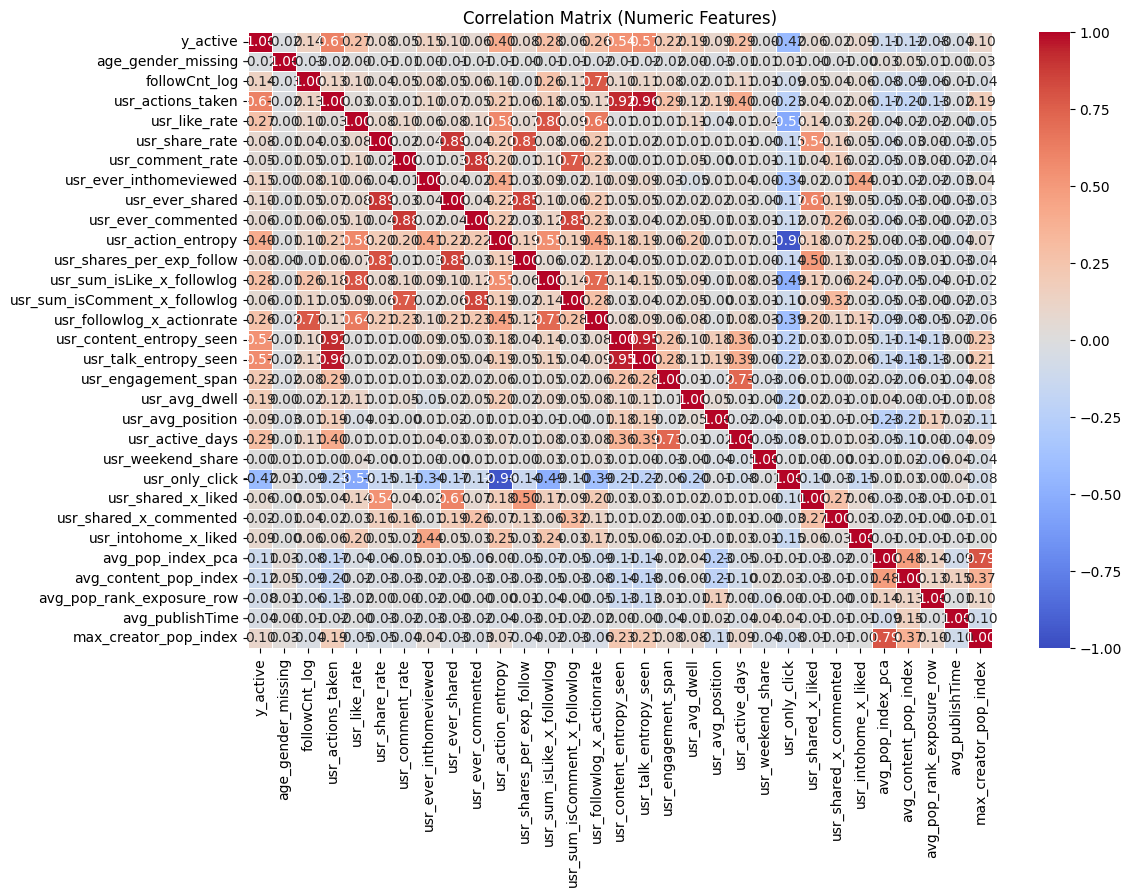

In [223]:
# Selecting only numeric columns for correlation
numeric_df = df_user.select_dtypes(include=["number"])

# Computing correlation matrix
corr = numeric_df.corr()

# Displaying as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

#### Interpretation
**High correlation between content entropy, talk entropy and amount of actions taken**

- This means that entropy features in our data are almost equivalent to early volume, not pure diversity
- For a clean and defensible final model: We will drop total actions and combine entropy features using PCA

**High correlation between only clicked and action entropy**

- One of these columns is almost a deterministic function of the other. They are measuring almost the same thing: “Does the user use only one simple action type, or do they mix multiple richer actions?"
- We will drop action entropy to demonstrate: Users who go beyond simple clicks (likes/shares/comments) in the early window are far more likely to become active later.


In [224]:
from sklearn.preprocessing import StandardScaler

# Combine user-level entropy and actions columns
df_e = df_user[['usr_content_entropy_seen', 'usr_talk_entropy_seen', 'usr_actions_taken']]

# Standardize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_e)

# PCA with one component
pca = PCA(n_components=1)
df_user['entropy_pca'] = pca.fit_transform(X_scaled)

# Keep the combined index
entropy_combined = df_user['entropy_pca']

# Drop columns no longer needed
df_user.drop(
    columns=['usr_content_entropy_seen', 'usr_talk_entropy_seen', 'usr_action_entropy', 'usr_actions_taken'],
    inplace=True,
    errors='ignore'
)



### 7.3. User-level distributions

In [225]:
# Print min, max, mean and std of all columns in df_user
print("User-level data summary statistics:")
print(df_user.describe().T[['min', 'max', 'mean','std']])



User-level data summary statistics:
                                    min         max          mean        std
y_active                       0.000000    1.000000  2.888911e-01   0.453259
age_gender_missing             0.000000    1.000000  9.757633e-01   0.153787
followCnt_log                  0.000000    6.118097  1.504790e+00   0.388973
usr_like_rate                  0.000000    1.000000  6.636350e-02   0.213512
usr_share_rate                 0.000000    1.000000  4.755718e-03   0.055046
usr_comment_rate               0.000000    1.000000  2.715173e-03   0.042947
usr_ever_inthomeviewed         0.000000    1.000000  3.767928e-02   0.190424
usr_ever_shared                0.000000    1.000000  9.294888e-03   0.095963
usr_ever_commented             0.000000    1.000000  5.097197e-03   0.071214
usr_shares_per_exp_follow      0.000000    1.000000  2.135732e-03   0.025797
usr_sum_isLike_x_followlog     0.000000   15.091314  2.184379e-01   0.755874
usr_sum_isComment_x_followlog  0.000000 

#### Summary of user-level feature distributions

- Many features are **binary or proportions in [0,1]** with strong mass at 0 and some rare positives  
- Several **log / index features** (`followCnt_log`, `usr_avg_dwell`, `usr_avg_position`, popularity indices) show right-skewed distributions with a few large values (heavy tails)  
- Interaction terms (`usr_sum_isLike_x_followlog`, `usr_sum_isComment_x_followlog`, `usr_followlog_x_actionrate`, `usr_shares_per_exp_follow`, `avg_pop_rank_exposure_row`) are also **heavily right-tailed**, reflecting rare high-engagement users  
- A few variables are **almost constant** across users (e.g. `age_gender_missing` ≈ 1 for nearly everyone) and carry little signal  

#### Conclusion

- To clean up the datset we will winsorize the most extreme heavy-tail features at high percentiles.

In [226]:
# Identify columns with heavy tails to cap
heavy_tail_cols = [
    'followCnt_log',
    'usr_sum_isLike_x_followlog',
    'usr_sum_isComment_x_followlog',
    'usr_followlog_x_actionrate',
    'usr_shares_per_exp_follow',
    'avg_pop_rank_exposure_row',
]

upper_q = 0.995  # cap at 99.5th percentile

for col in heavy_tail_cols:
    if col not in df_user.columns:
        continue
    upper = df_user[col].quantile(upper_q)
    df_user[col] = np.minimum(df_user[col], upper)


### 7.4. Saving the dataset

In [227]:
df_user.to_csv("../data/user_level_data.csv", index=False)
# Summary of user-level data
print(df_user.shape)
print(df_user.columns)


(20011, 30)
Index(['userId', 'y_active', 'province', 'age_gender_missing', 'followCnt_log',
       'usr_like_rate', 'usr_share_rate', 'usr_comment_rate',
       'usr_ever_inthomeviewed', 'usr_ever_shared', 'usr_ever_commented',
       'usr_shares_per_exp_follow', 'usr_sum_isLike_x_followlog',
       'usr_sum_isComment_x_followlog', 'usr_followlog_x_actionrate',
       'usr_engagement_span', 'usr_avg_dwell', 'usr_avg_position',
       'usr_active_days', 'usr_weekend_share', 'usr_only_click',
       'usr_shared_x_liked', 'usr_shared_x_commented', 'usr_intohome_x_liked',
       'avg_pop_index_pca', 'avg_content_pop_index',
       'avg_pop_rank_exposure_row', 'avg_publishTime', 'max_creator_pop_index',
       'entropy_pca'],
      dtype='object')
